# 4.Preprocessing

In [66]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [67]:
df = pd.read_csv("C:/Users/DELL/Documents/VEMV/pycaret/work/Projets_professionnels/Medical_expenses_estimation_project/data/raw/Medical cost.csv")
data = df.copy()
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [68]:
# Division en ensemble d'entrainement et de test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# car les smoker influencent beaucoup les charges
trainset, testset = train_test_split(data, train_size=0.8, shuffle=True, stratify= data['smoker'], random_state=0) 

In [69]:
# recréation des sous-ensembles de datsets
femmes = testset[testset['sex'] == 'female']
hommes = testset[testset['sex'] == 'male']

fumeurs = testset[testset['smoker'] == 'yes']
non_fumeurs = testset[testset['smoker'] == 'no']

In [70]:
data.shape

(1338, 7)

In [71]:
# gestion des NaN
def gestion_nan(df):
    df = df.dropna()
    #print(df.shape)
    return df

In [72]:
doublons = data.duplicated()
doublons.value_counts()

False    1337
True        1
Name: count, dtype: int64

In [73]:
# gestion des doublons
def gestion_doublons(df):
    df = df.drop_duplicates()
    return df

In [74]:
# encodage
#def encodage_categoriel(df):

 #   df.loc[df['sex'] == 'female', 'sex'] = 0
  #  df.loc[df['sex'] == 'male', 'sex'] = 1
   # df.loc[df['smoker'] == 'yes', 'smoker'] = 1
    #df.loc[df['smoker'] == 'no', 'smoker'] = 0
    #mean_charges_par_region = df.groupby('region')['charges'].mean()
    #df['region_encoded'] = df['region'].map(mean_charges_par_region)
    #df = df.drop('region', axis=1)
    #df = df.drop('sex', axis=1)
    #return df

In [75]:
def encodage_categoriel(df):
    cols = df.select_dtypes(include='object').drop(['region', 'sex'], axis=1).columns
    dummies = pd.get_dummies(df[cols], dtype=int)
    df = df.drop(columns=cols)
    df = df.drop(['region', 'sex'], axis=1)
    df = pd.concat([df, dummies], axis=1)
    return df

In [76]:
def normalisation(df):
   scaler = MinMaxScaler()
   cols_to_scale = df.select_dtypes(include=['number']).drop(['charges'], axis=1).columns 
   df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
   return df 

In [77]:
def preprocessing(df):
    df = gestion_nan(df)
    df = gestion_doublons(df)
    df = encodage_categoriel(df)
    #df = normalisation(df)
    #df = oversampling(df)
    x = df.drop('charges', axis=1)
    y = df['charges']
    return x, y

In [78]:
x_train, y_train = preprocessing(trainset)

In [79]:
x_test, y_test = preprocessing(testset)

## 

# 5. Modélisation

In [80]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error, r2_score, root_mean_squared_error
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression

In [81]:
PR = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SelectKBest(f_regression, k=19), LinearRegression())
#DT = make_pipeline(PolynomialFeatures(degree=2),DecisionTreeRegressor())
DT = DecisionTreeRegressor()
RG = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), Ridge())
RF = RandomForestRegressor(n_estimators=50)
SVM = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), SVR(kernel='linear', epsilon=0.1, C=1000 )) #, gamma=0.001))


In [82]:
def evaluation(model):
    y_train_log = np.log(y_train)
    model.fit(x_train, y_train_log)
    y_pred_log = model.predict(x_test)
    y_pred = np.exp(y_pred_log)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse}')
    print(f'MAE:  {mae}')
    print(f'RMSLE:  {rmsle}')
    print(f'R2:  {r2}')

    residus = (y_test - y_pred)
    residus = pd.DataFrame(residus)

    N, train_score, val_score = learning_curve(model, x_train, y_train_log, 
                                               cv=4, scoring='neg_root_mean_squared_error', train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(N, train_score.mean(axis=1), label= 'Training')
    plt.plot(N, val_score.mean(axis=1), label='Validation')
    plt.ylabel('RMSLE')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(residus, label='Résidus', kde=True)
    plt.legend()

RMSE: 4016.3840381449336
MAE:  2081.173541795136
RMSLE:  0.3204329442648251
R2:  0.8919341516907953


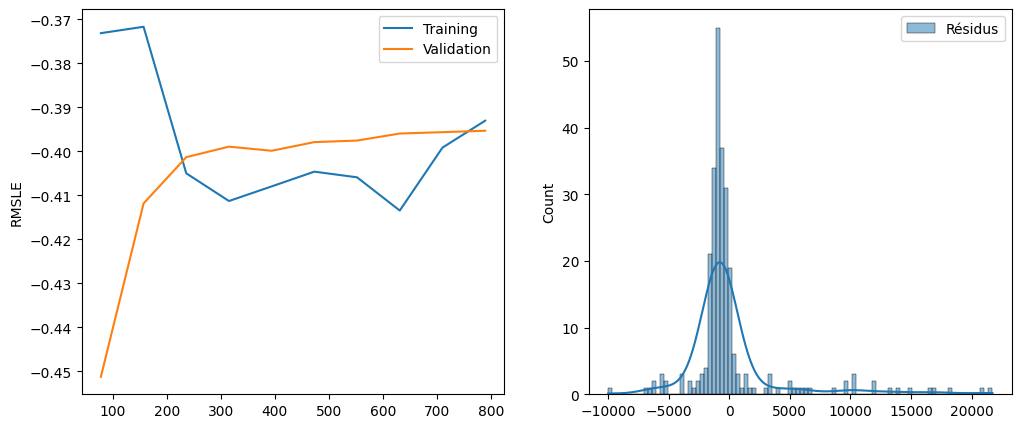

In [83]:
evaluation(PR)

RMSE: 4026.3523358845914
MAE:  2076.7316532201494
RMSLE:  0.32069401906471207
R2:  0.8913970669212554


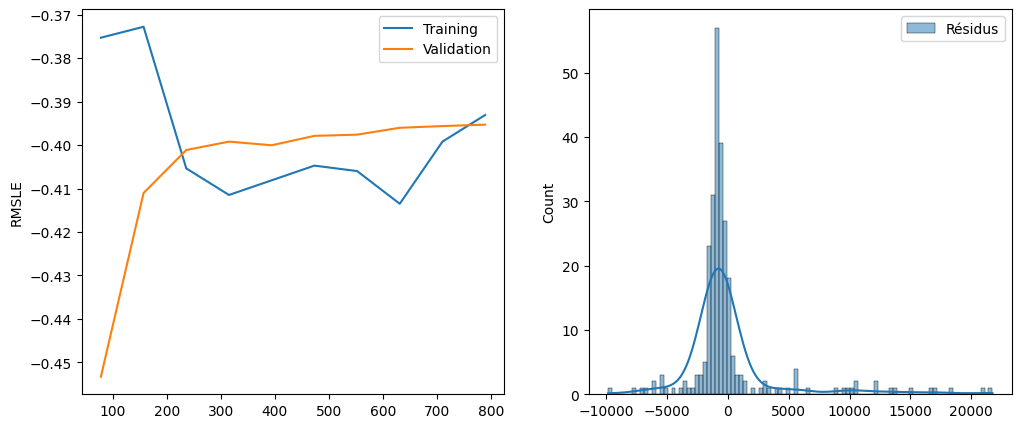

In [84]:
evaluation(RG)

In [85]:
# Affichage des coefficients

# Récupérer les noms des features crées par polynomial features
poly = PR.named_steps['polynomialfeatures'].get_feature_names_out(x_train.columns)

# récupérer les indices selectionnés par selectkbest
selected_indices = PR.named_steps['selectkbest'].get_support(indices=True)

# appliquer les indices pour avoir les noms finaux des variables selectionnées
selected_feature_names = poly[selected_indices]

# récuperer les coefficients appris par le modèle ridge
coefficients = PR.named_steps['linearregression'].coef_

# Associer les noms des variables
coeff_df = pd.DataFrame({ 
    'Feature': selected_feature_names,
    'coefficient': coefficients
    })


C:\Users\DELL\AppData\Local\Temp\ipykernel_24240\2106678949.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coeff_df.head(20), x='coefficient', y='Feature', palette='coolwarm')


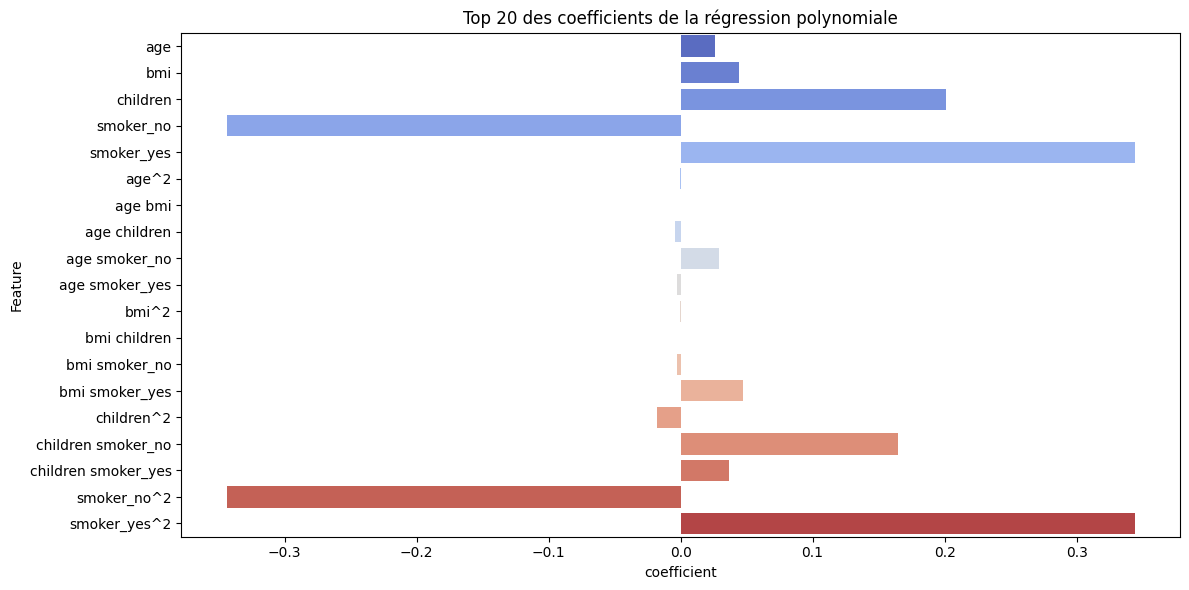

In [86]:
# Affichage des coefficients les plus élevés
plt.figure(figsize=(12, 6))
sns.barplot(data=coeff_df.head(20), x='coefficient', y='Feature', palette='coolwarm')
plt.title('Top 20 des coefficients de la régression polynomiale')
plt.tight_layout()

# Conclusion et prise de décision

Le modèle de **régrssion polynomiale** s'est avéré etre le meilleur modèle pour notre projet de modélisation des charges médicales dans le but d'estimer de manière fiable les charges médicales futures de ses clients afin d'ajuster ses primes d'assurance.
En effet, avec un **RMSLE de 0.32** notre modèle effectue les prédictions dans un intervalle fiable de **[charges réelles - charges réelles * 0.37; charges réelles - charges réelles * 0.37]**. Les bornes de cet intervalle étant des valeurs extremes et rares. De plus, comme nous pouvons le constater sur notre distribution des erreurs, il y'a une certaine normalité dans les résidus, preuve que les prédictions de notre modèle ne sont pas biaisées (sont objectives et suivent une logique claire). Par ailleurs, **un R2 de 89%** signifie que notre modèle explique **88% de la variance des charges médicales**.

Par ailleurs, le **schéma ci-dessus** présente l'influence de chaque variable sur les charges médicales.  